# 手で作ったサンプルデータを用いて、交絡因子と交互作用項をロジスティック回帰モデルで検討する

In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', 100)

# データ読み込み

In [3]:
#サンプルデータの読み込み
df_conf = pd.read_csv('./data/sample_data_confounding.csv')

#切片用のカラムを追加
df_conf["intercept"] = 1
df_conf.head()

,id,alcohol,smoking,cancer,DNA,intercept
0,1,1,1,1,1,1
1,2,1,1,1,1,1
2,3,1,1,1,1,1
3,4,1,1,1,1,1
4,5,1,1,1,1,1


In [4]:
pd.crosstab(df_conf['alcohol'], df_conf['cancer'])

cancer,0,1
alcohol,,
0,244,52
1,239,102


# 交絡因子

## 単変数ロジスティック回帰（粗オッズ）

In [5]:
X = df_conf[ ['intercept', 'alcohol'] ]
y = df_conf['cancer']

In [6]:
logit = sm.GLM(y, X, family=sm.families.Binomial())
logit_result = logit.fit()
print( logit_result.summary() )

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cancer   No. Observations:                  637
Model:                            GLM   Df Residuals:                      635
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -345.62
Date:                Tue, 13 Jul 2021   Deviance:                       691.25
Time:                        22:43:41   Pearson chi2:                     637.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.5459      0.153    -10.121      0.0

# ２変数ロジスティック回帰モデル（喫煙有無による調整）

In [7]:
X = df_conf[ ['intercept', 'alcohol', 'smoking'] ]
y = df_conf['cancer']

In [8]:
logit = sm.GLM(y, X, family=sm.families.Binomial())
logit_result = logit.fit()
print( logit_result.summary() )

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cancer   No. Observations:                  637
Model:                            GLM   Df Residuals:                      634
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -332.22
Date:                Tue, 13 Jul 2021   Deviance:                       664.44
Time:                        22:43:50   Pearson chi2:                     637.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.8664      0.174    -10.738      0.0

## 喫煙有無と飲酒　交互作用はなし

In [9]:
df_pivot = pd.pivot_table(data=df_conf, index=["alcohol", "smoking"], columns="cancer", values="id", aggfunc="count").reset_index()
df_pivot["log-odd"] = np.log( df_pivot[1]/df_pivot[0] )
df_pivot

cancer,alcohol,smoking,0,1,log-odd
0,0,0,197,30,-1.882006
1,0,1,47,22,-0.759105
2,1,0,98,20,-1.589235
3,1,1,141,82,-0.542041


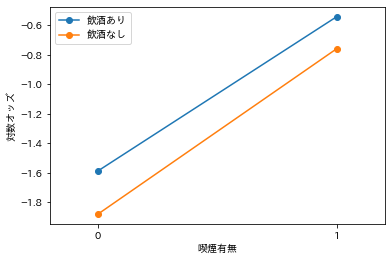

In [10]:
plt.plot([1,0], [ df_pivot.query("(alcohol==1) & (smoking==1)")["log-odd"], df_pivot.query("(alcohol==1) & (smoking==0)")["log-odd"] ],\
         label="飲酒あり", marker="o")
plt.plot([1,0], [ df_pivot.query("(alcohol==0) & (smoking==1)")["log-odd"], df_pivot.query("(alcohol==0) & (smoking==0)")["log-odd"] ],\
        label="飲酒なし", marker="o")
plt.ylabel("対数オッズ")
plt.xlabel("喫煙有無")
plt.xticks([0,1])
plt.xlim(-0.2,1.2)
plt.legend()

# 交互作用項を入れたモデルも一応作ってみる

In [11]:
df_conf['alcohol*smoking'] = df_conf['alcohol'] * df_conf['smoking']

In [12]:
X = df_conf[ ['intercept', 'alcohol', 'smoking', 'alcohol*smoking'] ]
y = df_conf['cancer']

In [13]:
logit = sm.GLM(y, X, family=sm.families.Binomial())
logit_result = logit.fit()
print( logit_result.summary() )

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cancer   No. Observations:                  637
Model:                            GLM   Df Residuals:                      633
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -332.20
Date:                Tue, 13 Jul 2021   Deviance:                       664.41
Time:                        22:44:38   Pearson chi2:                     637.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -1.8820      0.196     

# 遺伝子との交互作用

## 交互作用の確認

In [14]:
df_pivot2 = pd.pivot_table(data=df_conf, index=["smoking", "DNA"], columns="cancer", values="id", aggfunc="count").reset_index()
df_pivot2["log-odd"] = np.log( df_pivot2[1]/df_pivot2[0] )
df_pivot2

cancer,smoking,DNA,0,1,log-odd
0,0,0,140,15,-2.233592
1,0,1,155,35,-1.488077
2,1,0,92,10,-2.219203
3,1,1,96,94,-0.021053


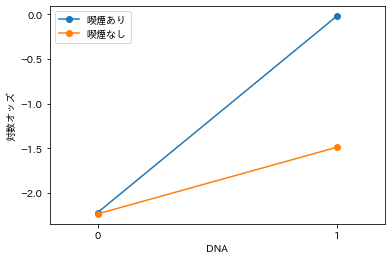

In [15]:
plt.plot([1,0], [ df_pivot2.query("(smoking==1) & (DNA==1)")["log-odd"], df_pivot2.query("(smoking==1) & (DNA==0)")["log-odd"] ],\
         label="喫煙あり", marker="o")
plt.plot([1,0], [ df_pivot2.query("(smoking==0) & (DNA==1)")["log-odd"], df_pivot2.query("(smoking==0) & (DNA==0)")["log-odd"] ],\
        label="喫煙なし", marker="o")
plt.ylabel("対数オッズ")
plt.xlabel("DNA")
plt.xticks([0,1])
plt.xlim(-0.2,1.2)
plt.legend()

## 交互作用項を入れたモデル

In [16]:
df_conf['smoking*DNA'] = df_conf['smoking'] * df_conf['DNA']

In [17]:
X = df_conf[ ['intercept', 'smoking', 'smoking*DNA'] ]
y = df_conf['cancer']

In [18]:
logit = sm.GLM(y, X, family=sm.families.Binomial())
logit_result = logit.fit()
print( logit_result.summary() )

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cancer   No. Observations:                  637
Model:                            GLM   Df Residuals:                      634
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -307.17
Date:                Tue, 13 Jul 2021   Deviance:                       614.34
Time:                        22:45:32   Pearson chi2:                     637.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.7750      0.153    -11.606      

## 比較対象　喫煙有無だけの粗オッズモデル

In [19]:
X = df_conf[ ['intercept', 'smoking'] ]
y = df_conf['cancer']

In [20]:
logit = sm.GLM(y, X, family=sm.families.Binomial())
logit_result = logit.fit()
print( logit_result.summary() )

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 cancer   No. Observations:                  637
Model:                            GLM   Df Residuals:                      635
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -332.91
Date:                Tue, 13 Jul 2021   Deviance:                       665.82
Time:                        22:46:30   Pearson chi2:                     637.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.7750      0.153    -11.606      0.0